### Import main functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [2]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [3]:
from plot_helpers import show_image, plot_clusters
from dataset_helpers import is_dmso, get_label
from dataset_helpers import low_clip, mean_clip, low_clip, minmax, max_normalise

In [4]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, BatchNormalization, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [5]:
def unishuffle(a, b, random_state=RS):
    assert len(a) == len(b)
    if random_state:
        np.random.seed(RS)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Read dataset

In [6]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')

In [7]:
y = npzfile['y']

In [8]:
y_dmso = np.array([get_label(i) for i in y])

In [9]:
X = npzfile['x']

## Image reconstruction

In [90]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val 
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(1920,3840)

def get_mask(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1),2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    return convert_to_binary(center[label])

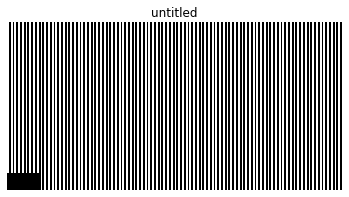

In [91]:
show_image(get_mask(new_img))

In [83]:
X[90].dtype

dtype('float32')

In [89]:
new_img.shape

(1920, 3840)

In [30]:
def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.reshape((x.shape))

In [26]:
# work on reconstruction
new_img = np.ndarray(shape=(1920, 1920))

col = 0
y = 0
x = 0
for i in range(1000, 1100):
    new_img[x:x+192, y:y+192] = X[i]
    x = 192*col
    col += 1
    if col == 10:
        col = 0
        y += 192

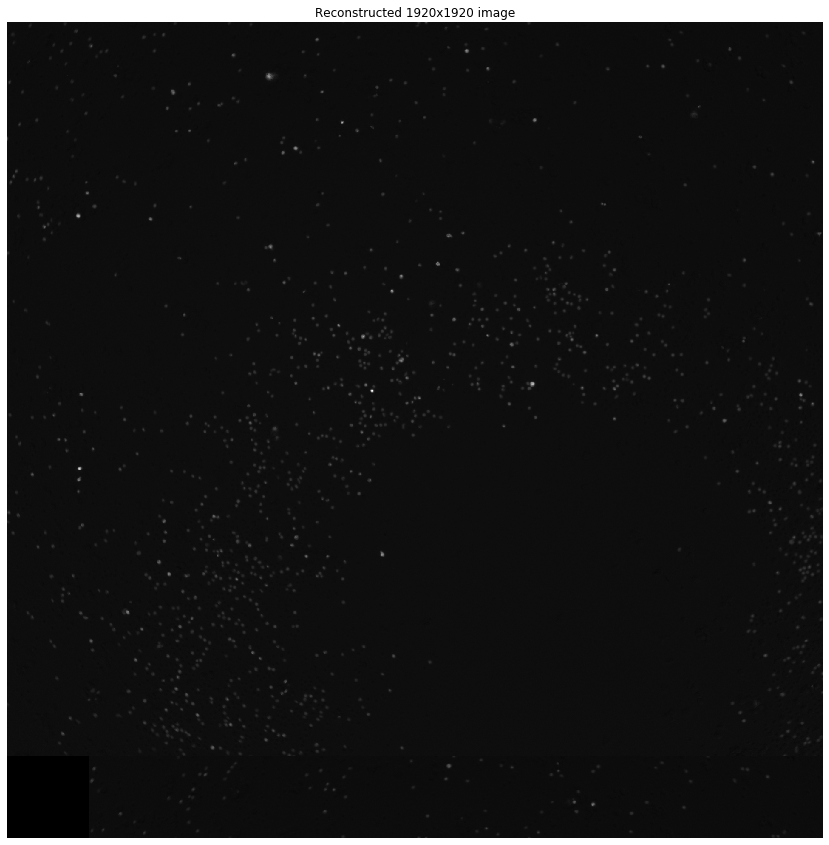

In [29]:
plt.figure(figsize=(15,15))
show_image(new_img, "Reconstructed 1920x1920 image")

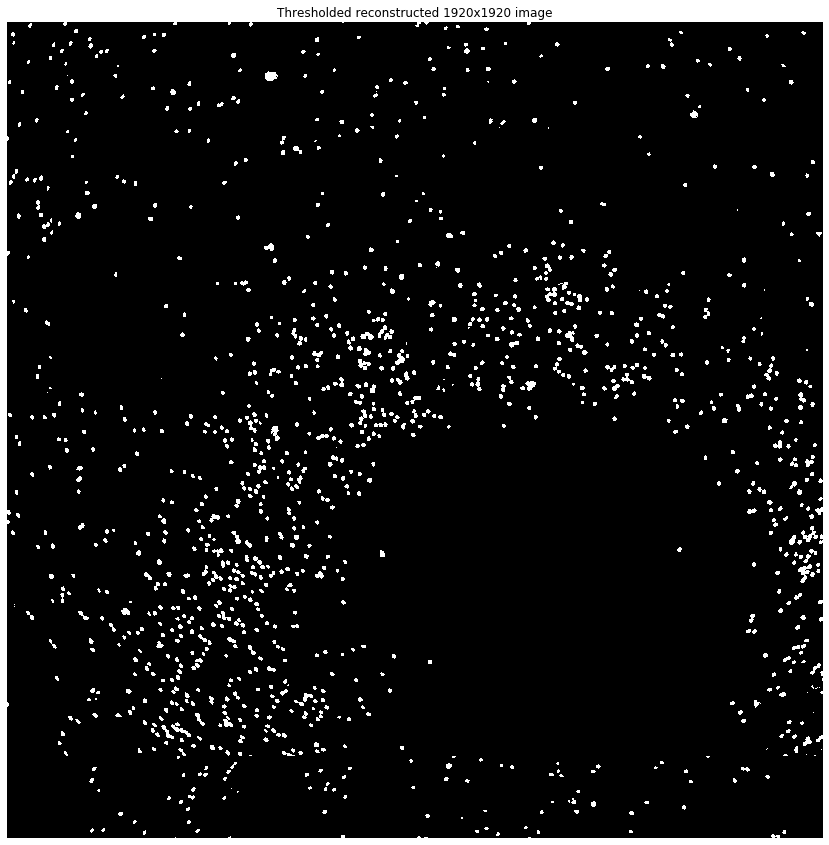

In [31]:
plt.figure(figsize=(15,15))
show_image(threshold(new_img), "Thresholded reconstructed 1920x1920 image")

In [56]:
from sklearn.cluster import KMeans

In [57]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val 
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(1920,1920)

def get_mask(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    sk_res = kmeans.cluster_centers_[kmeans.labels_]
    return convert_to_binary(sk_res)

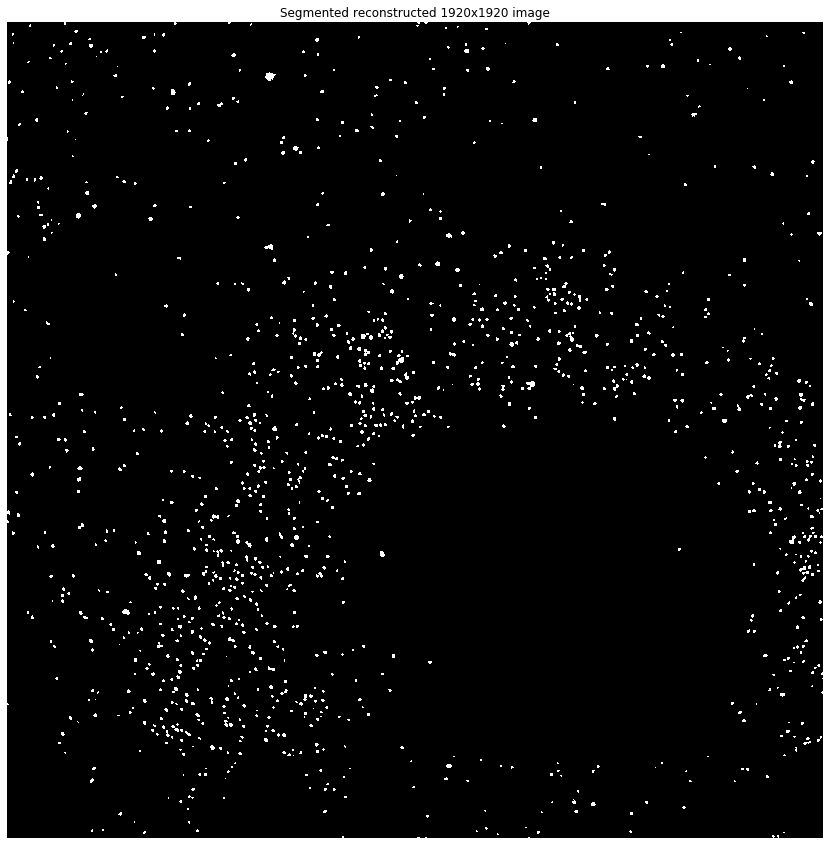

In [58]:
plt.figure(figsize=(15,15))
show_image(get_mask(new_img), "Segmented reconstructed 1920x1920 image")

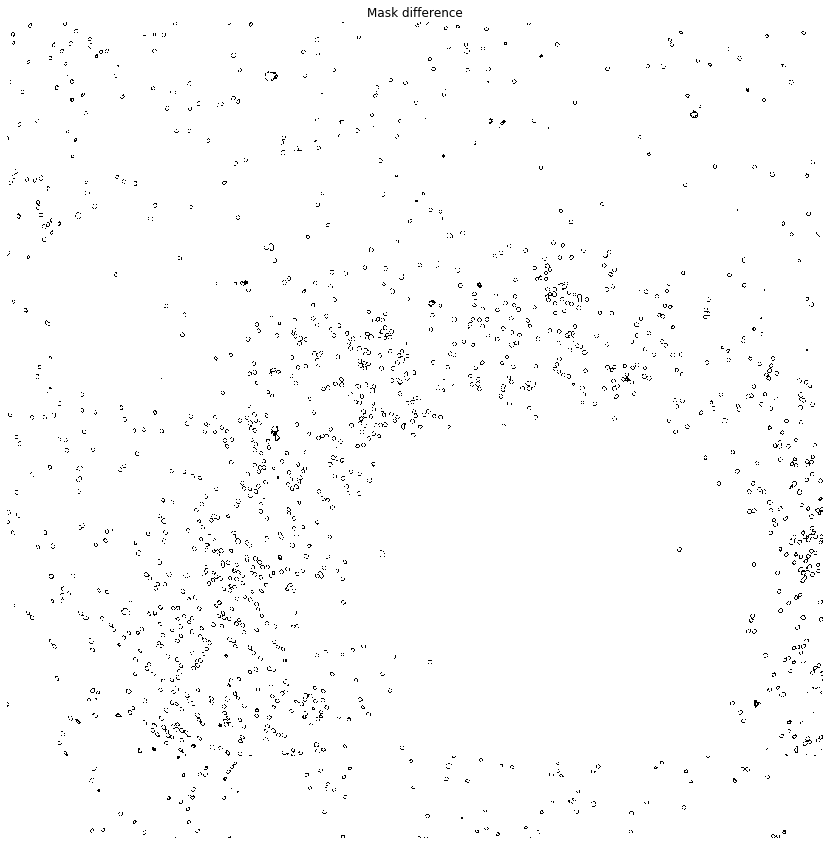

In [61]:
plt.figure(figsize=(15,15))
show_image(get_mask(new_img)-threshold(new_img), "Mask difference")

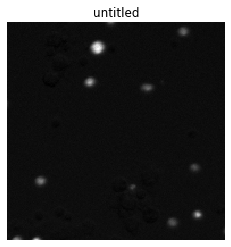

In [17]:
show_image(X[1050])

In [14]:
y[800]

'/Volumes/TARDIS/CK19/CK19 - N - 5(fld 1 wv FITC - FITC).tif'

In [10]:
y[900]

'/Volumes/TARDIS/CK19/CK19 - N - 5(fld 1 wv TexasRed - TexasRed).tif'

In [11]:
y[1000]

'/Volumes/TARDIS/CK19/CK19 - N - 8(fld 1 wv FITC - FITC).tif'

In [13]:
y[1099]

'/Volumes/TARDIS/CK19/CK19 - N - 8(fld 1 wv FITC - FITC).tif'

## Outliers and normalisation

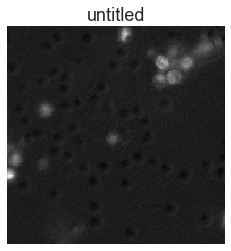

In [47]:
show_image(X[19586])

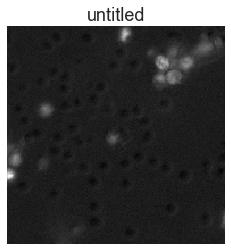

In [48]:
show_image(max_normalise(X[19586]))

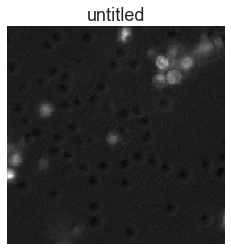

In [49]:
show_image(minmax(X[19586]))

In [53]:
max_normalise(X[19586]).min()

0.30980393

In [54]:
minmax(X[19586]).min()

0.0

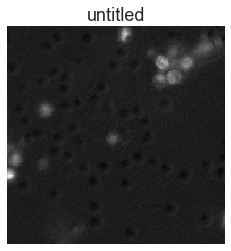

In [50]:
show_image(low_clip(X[19586]))

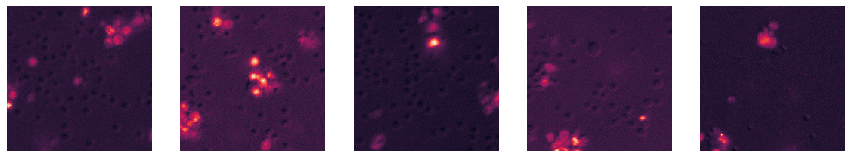

In [42]:
plot_range(X, rn=19585)

In [44]:
X[19585].max()

1137.0

In [15]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

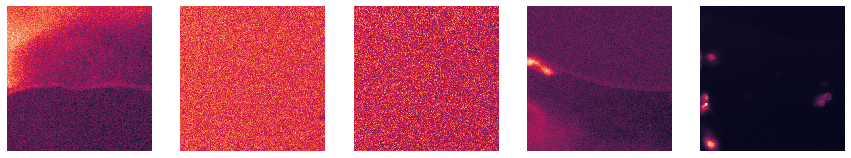

In [37]:
plot_range(X, rn=983)

In [38]:
y[983]

'/Volumes/TARDIS/CK19/CK19 - N - 5(fld 1 wv TexasRed - TexasRed).tif'

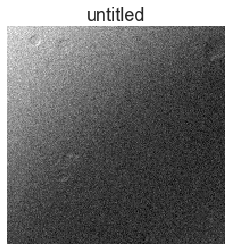

In [20]:
show_image(X[55]/np.max(X[55]))

### Helper functions for evaluating model

In [9]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data, test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

In [10]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
    idx = np.random.randint(1, len(images)+1)
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:l]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Choose random image to predict for
    activations = activation_model.predict(images[idx-1:idx])

    layer_names = []
    for layer in model.layers[1:l]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 65535).astype('uint16')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

### Human visualisation of different drug conditions

In [15]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

In [27]:
X = npzfile['x']

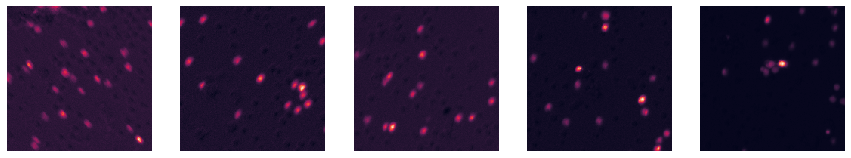

In [18]:
plot_range(X)

In [19]:
maxd = np.max(X)

In [21]:
X_12bit = X / maxd

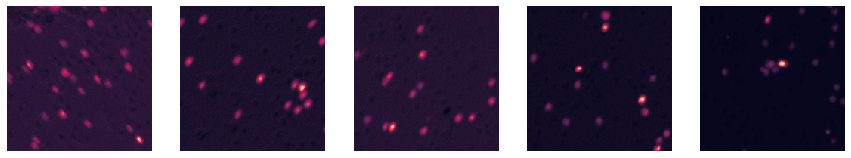

In [22]:
plot_range(X_12bit)

In [25]:
c=3
idx = 0
j = 0
x_combined = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_combined = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        x_combined[j, :, :, 0] = X[idx] / maxd
        x_combined[j, :, :, 1] = X[idx+100] / maxd
        y_combined[j] = y_dmso[idx]
        idx+=1
        j+=1

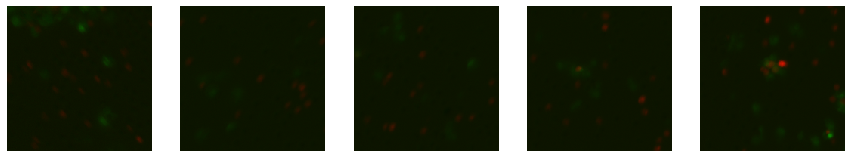

In [26]:
plot_range(x_combined)

In [28]:
c=3
idx = 0
j = 0
X_cc = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_cc = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        X_cc[j, :, :, 0] = low_clip(X[idx]) / maxd
        X_cc[j, :, :, 1] = low_clip(X[idx+100]) / maxd
        y_cc[j] = y_dmso[idx]
        idx+=1
        j+=1

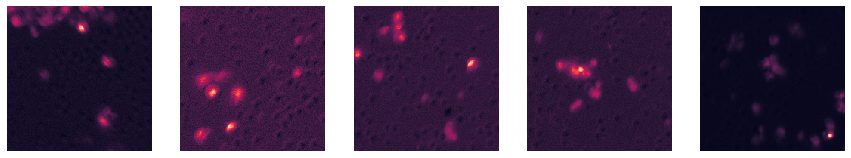

In [32]:
plot_range(X_cc[:,:,:,1])

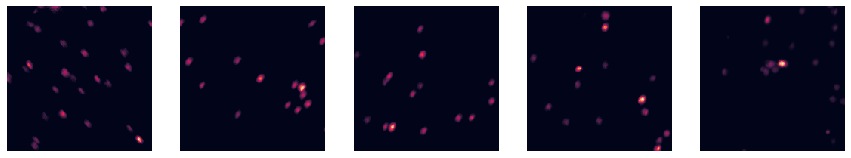

In [33]:
plot_range(X_cc[:,:,:,0])

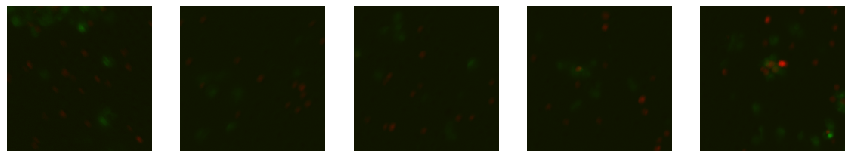

In [34]:
plot_range(X_cc)

In [ ]:
X = npzfile['x']
idx = 0
j = 0
X_cc2 = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_cc2 = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        X_cc2[j, :, :, 0] = max_normalise(X[idx])
        X_cc2[j, :, :, 1] = max_normalise(X[idx+100])
        y_cc2[j] = y_dmso[idx]
        idx+=1
        j+=1

In [ ]:
plot_range(X_cc2)

In [0]:
unstimulated = x_combined[y_combined==0]

In [0]:
ova = x_combined[y_combined==1]

In [0]:
cona = x_combined[y_combined==2]

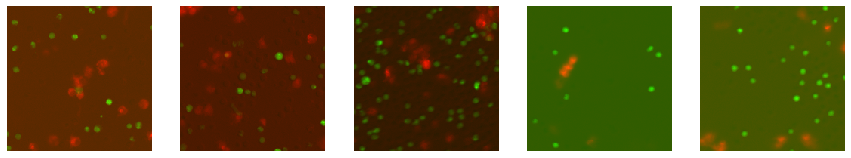

In [0]:
plot_range(unstimulated, rn=9)

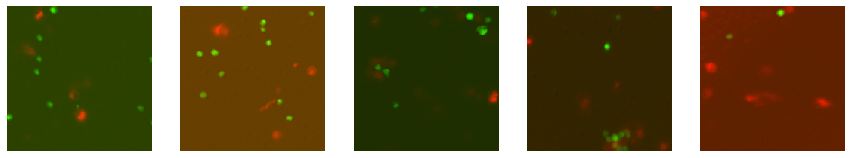

In [0]:
plot_range(ova, rn=9)

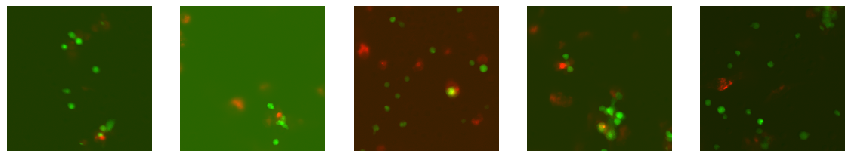

In [0]:
plot_range(cona, rn=9)